In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings('ignore')

## 문제1. MasterCard 리뷰 데이터셋을 사용해서 고객 트윗의 감성을 분석하는 간단한 모델을 만들어봅시다.

#### MasterCardReview : 2018년도부터 2022년도까지 마스터카드의 공식 트위터 계정이 태그된 트윗들과 해당 트윗들의 감성이 분류된 데이터셋

- datetime: 트윗 업로드 일시
- username: 사용자
- content: 트윗 원문
- preprocessed_content: 전처리된 트윗
- sentiment: 해당 트윗의 감성 (긍정(0) / 중립(1) / 부정(2)으로 구분)

1. MasterCardReview.csv 파일을 불러오고 출력해주세요. (1점)

In [ ]:
master = pd.read_csv("MasterCardReview.csv")
master.head()

,"In this comprehensive dataset, we have compiled an extensive collection of Twitter reviews from MasterCard customers spanning from 2018 to 2022.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,The dataset not only captures the tweets thems...,NaN,NaN,NaN,NaN,NaN
1,"By analyzing this data, researchers can gain a...",NaN,NaN,NaN,NaN,NaN
2,NaN,datetime,username,content,preprocessed_content,sentiment
3,0,2018-01-01 16:30:03+00:00,tunein,"What happens when we take risks, take control ...",happen take risk take control redefin relation...,1
4,1,2018-01-02 18:10:09+00:00,MediaPost,Electronics Such As Amazon Echo Win The Holida...,electron amazon echo win holiday user spending...,0


2. 화면에 출력된 데이터가 조금 이상해보입니다. MasterCardReview 데이터셋에는 첫번째 열에 이미 인덱스열이 있지만 판다스는 데이터를 로드하며 자동으로 인덱스열을 추가합니다. 또, MasterCardReview 데이터의 처음 세개 행에는 무의미한 데이터 소개가 포함되어 있습니다. 따라서 인덱스열로 첫번째 열을 지정하여 불필요한 인덱스열이 추가되지 않게 하고, 처음 세개의 행은 건너뛰고 데이터를 불러와주세요. 불러온 데이터는 df 변수에 저장해주세요. (1점)
- (read_csv() 함수의 index_col 파라미터와 skiprows 파라미터를 사용하시면 됩니다)

In [ ]:
master = pd.read_csv("MasterCardReview.csv",index_col=0,skiprows=3)
master.head()

,datetime,username,content,preprocessed_content,sentiment
0,2018-01-01 16:30:03+00:00,tunein,"What happens when we take risks, take control ...",happen take risk take control redefin relation...,1
1,2018-01-02 18:10:09+00:00,MediaPost,Electronics Such As Amazon Echo Win The Holida...,electron amazon echo win holiday user spending...,0
2,2018-01-02 23:19:11+00:00,mgiffhorn,Electronics Such As Amazon Echo Win The Holida...,electron amazon echo win holiday user spending...,0
3,2018-01-03 09:18:34+00:00,stoullieux,Mastercard SpendingPulse: Retail Sales Grew 4....,mastercard spendingpuls retail sale grew perce...,0
4,2018-01-03 12:33:07+00:00,ashoori_2010,"@MastercardNews Hello, your new app ( MASTER P...",user hello new app master pass avail play stor...,0


3. preprocessed_content 칼럼과 sentiment 칼럼을 넘파이 array로 변환하여 각각 x_array 변수에, y_array 변수에 저장해주세요. (1점)

In [ ]:
x_array = master['preprocessed_content'].to_numpy()
y_array = master['sentiment'].to_numpy()

In [ ]:
x_array

array(['happen take risk take control redefin relationship money find fortun favor bold new podcast user storylab amp user http',
       'electron amazon echo win holiday user spendingpuls retail http user http',
       'electron amazon echo win holiday user spendingpuls retail http user',
       ..., 'mastercard crypto tool combat fraud http user user',
       'invit becom hi http web bank nft mastercard debitcard crypto stake trade earn api nftart superrar user user user user user user user user http',
       'call new financi paradigm peopl particip current system part new one either user user co founder featur user piec highlight womenintech check http'],
      dtype=object)

설명변수에 해당하는 전처리된 트윗을 모델에 돌리기 위해 사이킷런의 TfidfVectorizer를 활용하여 문자를 숫자로 변환하겠습니다. 아래의 코드를 실행해주세요.

In [ ]:
# 말뭉치에 등장한 각 단어의 TF-IDF 계산
tfidf = TfidfVectorizer(use_idf=True)
x_tfidf = tfidf.fit_transform(x_array)
x_tfidf_array = x_tfidf.toarray()

#테이블 형태로 출력해보기
pd.DataFrame(x_tfidf_array)

,0,1,2,3,4,5,6,7,8,9,...,11335,11336,11337,11338,11339,11340,11341,11342,11343,11344
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


실행결과 나타나는 테이블의 행은 각 레코드(Document), 이 경우에는 트윗을 의미합니다. 열은 전체 말뭉치, 이 경우에는 전체 트윗들에 등장한 고유 단어(Term)를 의미합니다. 그리고 각 셀은 단어의 중요도를 나타냅니다. 다만, 이것은 풀이 과정의 이해를 돕기 위한 추가 내용일 뿐이니 지금은 모델 학습을 위해 문자를 숫자로 바꾸어주었다는 것만 기억해도 무방합니다.

4. x_tfidf_array와 y_array를 사이킷런의 train_test_split을 이용하여 훈련 데이터와 테스트 데이터로 분할해 주세요 (test_size는 0.2로 설정해주세요). (1점)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_tfidf_array, y_array, test_size=0.2)



5. torch의 from_numpy() 함수를 사용하여 분할된 훈련 데이터와 테스트 데이터로 텐서를 생성하여 각각 X_train, X_test, y_train, y_test 변수에 저장해주세요. 이때 훈련 데이터와 테스트 데이터의 설명 변수는 float 타입으로, 목적 변수는 long 타입으로 설정해주세요. 그리고 텐서로 변환한 훈련데이터의 설명변수(X_train)와 목적변수(y_train)의 shape을 출력해주세요. (1점)

In [ ]:
X_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

In [ ]:
X_train.shape

torch.Size([9698, 11345])

6. 이제 신경망을 구성하겠습니다. 적절한 코드를 작성하여 입력층, 출력층이 1개씩 있고, 은닉층이 5개인 신경망을 구성해주세요. 이때, 은닉층의 노드의 수는 모두 256개로 통일하고, 입력층과 출력층의 노드의 수는 지금까지의 과정을 생각해 적절하게 선택해주세요. 또, 각 계층은 모두 선형 계층으로 nn.Linear로 통일해주세요. (아래 코드의 주석을 참고해 주세요) (1점)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Linear(11345,256)
        self.layer2 = nn.Linear(256,256)
        self.layer3 = nn.Linear(256,256)
        self.layer4 = nn.Linear(256,256)
        self.layer5 = nn.Linear(256,256)
        self.layer6 = nn.Linear(256,256)
        self.layer7 = nn.Linear(256,3)


    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        x = F.relu(self.layer6(x))
        x = self.layer7(x)
        return F.log_softmax(x)

# 인스턴스 생성
model = Net()

7. 모델 학습을 위한 손실함수와 옵티마이저를 정의하겠습니다. 손실함수는 CrossEntropyLoss로 정의하여 loss_function 변수에 저장하고, 옵티마이저는 Adam으로 정의하여 optimizer 변수에 저장해주세요(학습률은 0.005로 설정해주세요). (1점)

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.005)

8. 모델을 학습시키겠습니다. 아래 코드의 세 개의 주석 #경사 초기화, #오차 역전파 계산, #가중치 업데이트 부분에 각각의 기능을 수행하는 적절한 코드를 작성하고 실행해 주세요. (1점)

In [ ]:
epochs = 100

for i in range(epochs):
    i += 1
    y_pred = model(X_train)
    single_loss = loss_function(y_pred, y_train)

    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    #경사 초기화
    optimizer.zero_grad()

    #오차 역전파 계산
    single_loss.backward()
    #가중치 업데이트
    optimizer.step()
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 1.09257805
epoch:  11 loss: 0.79496109
epoch:  21 loss: 0.26287663
epoch:  31 loss: 0.06062154
epoch:  41 loss: 0.02690736
epoch:  51 loss: 0.01692359
epoch:  61 loss: 0.01278319
epoch:  71 loss: 0.01067127
epoch:  81 loss: 0.00934941
epoch:  91 loss: 0.00839674
epoch: 100 loss: 0.0087892143


9. 모델을 평가하겠습니다. 아래 코드를 실행해 주세요. (1점)

In [ ]:
with torch.no_grad():
    y_val = model(X_test)
    loss = loss_function(y_val, y_test)
print(f'Loss: {loss:.8f}')
y_val = np.argmax(y_val, axis=1)

Loss: 5.48732281


10. y_test와 y_val에 대하여 classification_report를 출력하고 모델의 성능을 확인해주세요. (1점)

In [ ]:

y_pred = model(X_train)
y_val = model(X_test)
y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
y_pred2 = torch.argmax(y_val, dim=1).detach().numpy()
print(classification_report(y_train.numpy(), y_pred))
print(classification_report(y_test.numpy(), y_pred2))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3960
           1       0.99      1.00      1.00      4044
           2       1.00      1.00      1.00      1694

    accuracy                           1.00      9698
   macro avg       1.00      1.00      1.00      9698
weighted avg       1.00      1.00      1.00      9698

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       993
           1       0.72      0.69      0.70      1040
           2       0.70      0.62      0.66       392

    accuracy                           0.71      2425
   macro avg       0.71      0.70      0.70      2425
weighted avg       0.71      0.71      0.71      2425



## 문제2.

1. 아래의 Table의 Data를 텐서로 직접 생성하시오, (변수명 = A) (1점)

In [ ]:
import os

path = os.getcwd()
path # 본인의 현재 코드 파일 경로 확인

'/content'

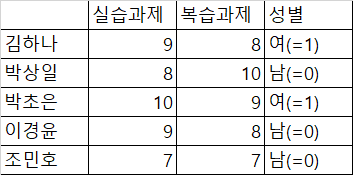

In [ ]:
from IPython.display import Image

Image('Table_1.png') # 이미지가 해당 경로의 폴더 안에 정상적으로 들어있어야 이미지가 로딩됩니다!

In [ ]:
A = torch.Tensor([[9,8,1],[8,10,0],[10,9,1],[9,8,0],[7,7,0]])
A

tensor([[ 9.,  8.,  1.],
        [ 8., 10.,  0.],
        [10.,  9.,  1.],
        [ 9.,  8.,  0.],
        [ 7.,  7.,  0.]])

2. 복습과제, 조민호, 여성에 해당하는 데이터들을 각각 Numpy식의 표준 인덱싱 혹은 슬라이싱으로 도출하시오 (1점)

In [ ]:
print(f"복습과제: ",A[:,1])
print(f"조민호: ",A[4,:])
print(f"여성: ",A[[0,2],:])

복습과제:  tensor([ 8., 10.,  9.,  8.,  7.])
조민호:  tensor([7., 7., 0.])
여성:  tensor([[ 9.,  8.,  1.],
        [10.,  9.,  1.]])


3. torch.ones를 활용하여 요소를 1로 가지는 Matrix를 만들어 A와 행렬곱 (Matrix Multiplication)을 계산하시오.(변수명=y1) 이렇게 만들어진 결과에 실습과제 점수 총합과 복습과제 점수 총합이 포함되어야 하며, 실습과제 점수 총합과 복습과제 점수 총합을 인덱싱 혹은 슬라이싱을 활용해 도출하시오. (1점)

In [ ]:
y1 = torch.ones(5,5)
print(f"행렬곱: ",y1@A)
print(f"실습과제 총합: ",43)
print(f"복습과제 총합: ",42)

행렬곱:  tensor([[43., 42.,  2.],
        [43., 42.,  2.],
        [43., 42.,  2.],
        [43., 42.,  2.],
        [43., 42.,  2.]])
실습과제 총합:  43
복습과제 총합:  42


4. 텐서 A를 Transpose 시키시오. (변수명 = A_T) (1점)

In [ ]:
A_T=np.transpose(A)

5. A_T와 A를 행렬곱(변수명=y2)하고 행렬곱의 요소 중 실습과제의 점수의 제곱합과 복습과제 점수의 제곱합을 도출하시오. (1점)

In [ ]:
y2 = A_T@A
y2
print(f"실습과제 제곱합: ",375)
print(f"복습과제 제곱합: ",358)

tensor([[375., 363.,  19.],
        [363., 358.,  17.],
        [ 19.,  17.,   2.]])

6. 특정 상수만을 요소로 가지는 텐서를 만들어 1-5로 나온 행렬곱 결과에 요소 곱을 하시오. 이 때 행렬곱에서 실습과제, 복습과제의 제곱합이었던 요소들이 분산으로 바뀌고 나머지 요소들은 0이 되도록 하시오. (2점)

In [ ]:
M=torch.tensor([[1.3/375,0,0],[0,1.3/358,0],[0,0,0]])
result = torch.mul(y2, M)
result

tensor([[1.3000, 0.0000, 0.0000],
        [0.0000, 1.3000, 0.0000],
        [0.0000, 0.0000, 0.0000]])

7. 아래의 Dataset class는 3가지의 함수를 구현한다. 각각의 함수의 역할이 무엇인지 답하시오. (1점)

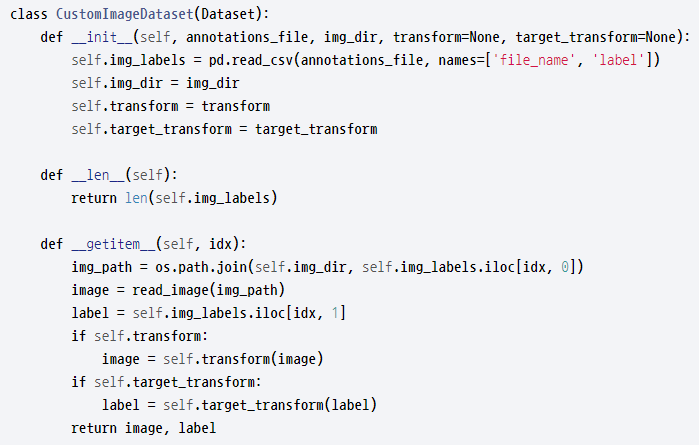

In [ ]:
Image('Class_1.png')

답안)__init__함수는 class를 instance로 구체화 하기위한 요소를 정의한다. 또한 초기화한다. 위에서 img_labels에 파일을 받고 img_dir에서는 입력한 img_dir을 transform도 정의한 transform을 target_transform도 정의한 것을 받는다.
def __len__는 받은 데이터의 길이를 return한다.

def__getitem__에서는 idx에 해당하는 img_path와 그에 해당하는 image, label을 받는다. 그리고 transform을 입력한다면 그에 맞는 transform을 적용하고 target_transform도 미리 정의된 것이 있다면 label에 적용하여 image, label반환한다.


8. 아래의 class에 대해 __init__과 forward의 기능을 포함하여 설명하시오. (2점)

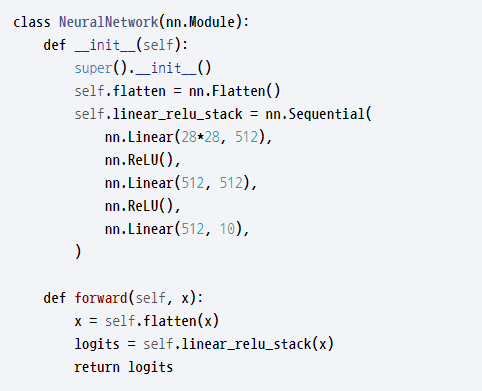

In [ ]:
Image('Class_2.png')


답안)처음 nn.Module을 상속받고 super()를 사용하여 상위 클래스의 생성자를 호출하여 상속받은 속성과 메서드를 초기화한다. 이후 flatten을 통해 1차원으로 풀어주고 이를 nn.sequential을 이용해 연속적인 layer를 쌓는다. 28*28차원을 flatten했다면 28X28차원 이므로 이를 linear에 input으로 받고 512차원으로 보낸다. 이후 활성화 함수 Relu취하고 다시 Linear로 보내 512 ->512차원이고 또 Relu씌우고 마지막은 필요한 output차원에 맞게 linear를 사용한다.
아러한 init부분은 class를 인스턴스로 구체화 하는 과정이다.


forward에서는 x를 입력받으면 이를 flatten하고 위에서 정의한 linear_relu_stack에 통과시켜 logits을 만들고 반환한다.
이때의 x는 인스턴스로 구체화한 model에 넣는 입력이다.
